<a href="https://colab.research.google.com/github/rashdiwsl/SignSecure-FE-BE/blob/Backend/Signature_Verification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q opencv-python-headless matplotlib gradio


In [ ]:
from google.colab import files
files.upload()  # This will ask you to upload the kaggle.json file


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d robinreni/cedar-signature-verification-dataset


In [ ]:
!kaggle datasets list -s cedar


In [ ]:
!kaggle datasets download -d shreelakshmigp/cedardataset

In [ ]:
!unzip cedardataset.zip -d /content/dataset

Archive:  cedardataset.zip
replace /content/dataset/signatures/Readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls -R /content/dataset

/content/dataset:
signatures

/content/dataset/signatures:
full_forg  full_org  Readme.txt

/content/dataset/signatures/full_forg:
forgeries_10_10.png  forgeries_26_22.png  forgeries_43_11.png
forgeries_10_11.png  forgeries_26_23.png  forgeries_43_12.png
forgeries_10_12.png  forgeries_26_24.png  forgeries_43_13.png
forgeries_10_13.png  forgeries_26_2.png   forgeries_43_14.png
forgeries_10_14.png  forgeries_26_3.png   forgeries_43_15.png
forgeries_10_15.png  forgeries_26_4.png   forgeries_43_16.png
forgeries_10_16.png  forgeries_26_5.png   forgeries_43_17.png
forgeries_10_17.png  forgeries_26_6.png   forgeries_43_18.png
forgeries_10_18.png  forgeries_26_7.png   forgeries_43_19.png
forgeries_10_19.png  forgeries_26_8.png   forgeries_43_1.png
forgeries_10_1.png   forgeries_26_9.png   forgeries_43_20.png
forgeries_10_20.png  forgeries_2_6.png	  forgeries_43_21.png
forgeries_10_21.png  forgeries_27_10.png  forgeries_43_22.png
forgeries_10_22.png  forgeries_27_11.png  forgeries_43_23.png
for

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Paths
data_path = "/content/dataset/signatures"
genuine_dir = os.path.join(data_path, "full_org")
forgery_dir = os.path.join(data_path, "full_forg")

# Parameters
IMG_SIZE = 128

def load_images_from_folder(folder, label):
    images, labels = [], []
    for filename in os.listdir(folder):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)   # grayscale
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))        # resize
            images.append(img)
            labels.append(label)
    return images, labels

# Load data
genuine_images, genuine_labels = load_images_from_folder(genuine_dir, 0) # 0 = genuine
forgery_images, forgery_labels = load_images_from_folder(forgery_dir, 1) # 1 = forgery

# Combine
X = np.array(genuine_images + forgery_images)
y = np.array(genuine_labels + forgery_labels)

# Normalize
X = X / 255.0
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # add channel

# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("✅ Data ready")
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


✅ Data ready
Train: (1848, 128, 128, 1) Val: (396, 128, 128, 1) Test: (396, 128, 128, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32
)


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.5419 - loss: 0.6865 - val_accuracy: 0.6944 - val_loss: 0.5903
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6771 - loss: 0.5955 - val_accuracy: 0.7601 - val_loss: 0.5313
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7477 - loss: 0.5128 - val_accuracy: 0.8131 - val_loss: 0.4396
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7819 - loss: 0.4547 - val_accuracy: 0.8333 - val_loss: 0.4022
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8374 - loss: 0.3811 - val_accuracy: 0.8283 - val_loss: 0.3943
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8811 - loss: 0.3150 - val_accuracy: 0.8510 - val_loss: 0.3798
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8929 - loss: 0.2691 - val_accuracy: 0.8687 - val_loss: 0.3281
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9015 - loss: 0.2506 - val_accuracy: 0.9116 - val_loss:

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.8584 - loss: 0.3689
Test Accuracy: 87.12%


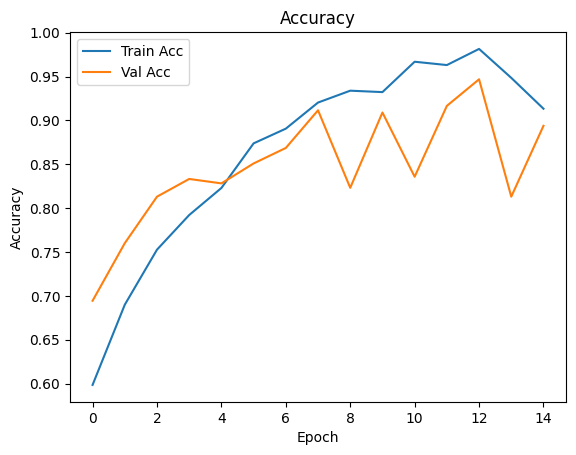

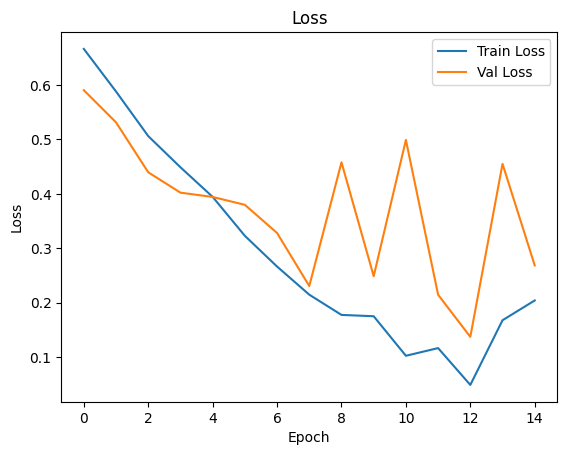

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1
)

datagen.fit(X_train)


In [ ]:
model.save('signature_cnn_model.h5')


In [ ]:
model.save('signature_cnn_model.keras')


In [ ]:
from google.colab import files

# This will open a file picker
uploaded = files.upload()


TypeError: 'NoneType' object is not subscriptable

In [ ]:
# uploaded is a dictionary of {filename: file_content}
for filename in uploaded.keys():
    print('Uploaded file:', filename)
    img_path = filename  # save the file path


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the image
img = image.load_img(img_path, target_size=(128,128), color_mode='grayscale')
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)
if prediction[0][0] > 0.5:
    print("Prediction: Genuine Signature")
else:
    print("Prediction: Forged Signature")


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the image
img = image.load_img(img_path, target_size=(128,128), color_mode='grayscale')

# Convert to array and normalize
img_array = image.img_to_array(img) / 255.0

# Add batch dimension
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)

# Show result
if prediction[0][0] > 0.5:
    print("Prediction: Genuine Signature")
else:
    print("Prediction: Forged Signature")


In [ ]:
model.save("signature_cnn_model.h5")


In [ ]:
from google.colab import files
files.download("signature_cnn_model.h5")
